In [18]:
!pip uninstall arabic-reshaper python-bidi -y



Found existing installation: arabic-reshaper 3.0.0
Uninstalling arabic-reshaper-3.0.0:
  Successfully uninstalled arabic-reshaper-3.0.0
Found existing installation: python-bidi 0.6.6
Uninstalling python-bidi-0.6.6:
  Successfully uninstalled python-bidi-0.6.6


In [1]:

import zipfile
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.isotonic import IsotonicRegression
import warnings
import arabic_reshaper
from bidi.algorithm import get_display

# --- بخش ۱: تنظیمات و توابع کمکی ---

# مسیر فایل ZIP حاوی داده‌های ارزیابی
# لطفاً مطمئن شوید این مسیر صحیح است.
ZIP_FILE_PATH = '/home/zeus/Projects/hb/multi_agent_llm_judge/calibration_data/evaluations.zip'

def setup_persian_font():
    """تنظیم فونت فارسی برای نمودارها و مدیریت حالت جایگزین."""
    try:
        plt.rcParams['font.family'] = 'B Nazanin'  # یا فونت فارسی دیگری که نصب دارید
        print("فونت 'B Nazanin' برای نمودارها تنظیم شد.")
    except:
        plt.rcParams['font.family'] = 'DejaVu Sans'
        print("هشدار: فونت 'B Nazanin' یافت نشد. از فونت جایگزین 'DejaVu Sans' استفاده می‌شود.")
    plt.rcParams['axes.unicode_minus'] = False

def reshape_text(text):
    """تابع کمکی برای اصلاح متن فارسی برای نمایش در نمودار."""
    return get_display(arabic_reshaper.reshape(str(text)))

# نادیده گرفتن هشدارهای غیرضروری
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- بخش ۲: استخراج و پردازش داده‌ها ---

def load_data_from_zip(zip_filepath):
    """
    داده‌ها را از فایل zip استخراج می‌کند و با ساختار دقیق JSON شما سازگار است.
    این تابع دو DataFrame برمی‌گرداند: یکی برای داده‌های اصلی و دیگری برای آرای عامل‌ها.
    """
    records = []
    agent_votes_list = []

    try:
        with zipfile.ZipFile(zip_filepath, 'r') as z:
            json_files = [f for f in z.namelist() if f.startswith('evaluations/') and f.endswith('.json')]
            print(f"تعداد {len(json_files)} فایل JSON در فایل zip پیدا شد.")
            
            for filename in json_files:
                with z.open(filename) as f:
                    try:
                        data = json.load(f)

                        jury_decision = data.get('jury_decision', {})
                        raw_confidence = data.get('jury_confidence') # اطمینان خام از ریشه JSON
                        weighted_confidence = jury_decision.get('weighted_confidence') # اطمینان وزن‌دار از jury_decision
                        human_verdict_str = data.get('human_verdict')

                        if raw_confidence is None or human_verdict_str is None or 'majority_verdict' not in jury_decision:
                            # print(f"هشدار: فایل {filename} فاقد داده‌های کلیدی است و نادیده گرفته شد.")
                            continue

                        # منطق برای effective_confidence (برای نمودار کالیبراسیون)
                        # اگر رأی هیئت منصفه "غلط" باشد، اطمینان را معکوس می‌کنیم
                        if jury_decision.get('majority_verdict') == 'incorrect':
                            effective_confidence = 1 - weighted_confidence if weighted_confidence is not None else None
                        else:
                            effective_confidence = weighted_confidence

                        is_human_correct = 1 if human_verdict_str == 'correct' else 0
                        is_system_correct = (jury_decision.get('majority_verdict') == human_verdict_str)

                        record = {
                            'eval_id': data.get('eval_id'),
                            'jury_verdict': jury_decision.get('majority_verdict'),
                            'raw_confidence': raw_confidence,
                            'effective_confidence': effective_confidence,
                            'consensus_level': jury_decision.get('consensus_level'),
                            'human_verdict': human_verdict_str,
                            'is_human_correct': is_human_correct,
                            'is_system_correct': is_system_correct
                        }
                        records.append(record)

                        # استخراج آرای عامل‌ها از تمام راندها
                        for round_data in data.get('rounds', []):
                            for agent in round_data.get('agents', []):
                                agent_votes_list.append({
                                    'eval_id': data.get('eval_id'),
                                    'agent_name': agent.get('name'),
                                    'agent_verdict': agent.get('verdict')
                                })

                    except (json.JSONDecodeError, AttributeError, KeyError) as e:
                        print(f"خطا در پردازش فایل {filename}: {e}")
    
    except FileNotFoundError:
        print(f"خطا: فایل {zip_filepath} یافت نشد.")
        return pd.DataFrame(), pd.DataFrame()

    df = pd.DataFrame(records)
    df_agent_votes = pd.DataFrame(agent_votes_list)
    return df, df_agent_votes

# --- بخش ۳: اجرای اصلی و رسم نمودارها ---

# اجرای تنظیمات اولیه
setup_persian_font()
main_df, agent_votes_df = load_data_from_zip(ZIP_FILE_PATH)

if main_df.empty:
    print("\nDataFrame خالی است! هیچ داده‌ای برای رسم نمودار وجود ندارد. لطفاً خطاها را بررسی کنید.")
else:
    print(f"\nتعداد کل رکوردهای معتبر بارگذاری شده: {len(main_df)}")
    print(f"تعداد کل آرای عامل‌ها استخراج شده: {len(agent_votes_df)}")
    
    # --- نمودار ۰: توزیع امتیاز اطمینان تعدیل‌شده (ادغام شده از اسکریپت اول شما) ---
    print("\n۰. رسم نمودار توزیع اطمینان تعدیل‌شده (بر اساس اسکریپت اول)...")
    adjusted_confidences = []
    for index, row in main_df.iterrows():
        # از ستون 'raw_confidence' که معادل 'jury_confidence' در کد اصلی شماست، استفاده می‌کنیم
        confidence = row['raw_confidence']
        verdict = row['jury_verdict']
        
        if pd.notna(confidence) and pd.notna(verdict):
            if verdict == 'correct':
                adjusted_confidences.append(confidence)
            elif verdict == 'incorrect':
                # این کار اطمینان را به سمت 0 می‌برد که نشان‌دهنده اطمینان به "غلط بودن" است
                adjusted_confidences.append(1 - confidence)

    plt.figure(figsize=(12, 7))
    sns.histplot(adjusted_confidences, bins=25, kde=True, color='green')
    plt.xlabel(reshape_text('امتیاز اطمینان'), fontsize=12)
    plt.ylabel(reshape_text('تعداد ارزیابی‌ها'), fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- کالیبراسیون داده‌ها (برای نمودار قابلیت اتکا) ---
    y_true = main_df['is_human_correct'].values
    # برای کالیبراسیون از effective_confidence استفاده می‌کنیم که همیشه بیانگر اطمینان به "صحیح بودن" است
    y_prob_raw = main_df['effective_confidence'].values

    valid_indices = ~np.isnan(y_prob_raw) & ~np.isnan(y_true)
    y_true_clean = y_true[valid_indices]
    y_prob_raw_clean = y_prob_raw[valid_indices]

    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(y_prob_raw_clean, y_true_clean)
    y_prob_calibrated = iso_reg.predict(y_prob_raw_clean)
    
    # --- رسم سایر نمودارها ---

    # ۱. نمودار توزیع اطمینان خام هیئت منصفه
    print("\n۱. رسم نمودار توزیع اطمینان هیئت منصفه (کالیبره نشده)...")
    plt.figure(figsize=(12, 7))
    sns.histplot(main_df['raw_confidence'].dropna(), bins=20, kde=True, color='dodgerblue')
    #plt.title(reshape_text('۱. توزیع اطمینان هیئت منصفه (مقادیر خام jury_confidence)'), size=16, pad=20)
    plt.xlabel(reshape_text('امتیاز اطمینان'), size=12)
    plt.ylabel(reshape_text('تعداد ارزیابی‌ها'), size=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # ۲. نمودار قابلیت اتکا (Reliability Diagram)
    print("۲. رسم نمودار قابلیت اتکا (قبل و بعد از کالیبراسیون)...")
    fig, ax = plt.subplots(figsize=(10, 8))
    CalibrationDisplay.from_predictions(y_true_clean, y_prob_raw_clean, n_bins=15, ax=ax, name=reshape_text('قبل از کالیبراسیون'), marker='o', linestyle='--')
    CalibrationDisplay.from_predictions(y_true_clean, y_prob_calibrated, n_bins=15, ax=ax, name=reshape_text('بعد از کالیبراسیون (Isotonic)'), marker='^', linestyle='-')
    #ax.set_title(reshape_text('۲. نمودار قابلیت اتکا'), size=16, pad=20)
    ax.set_xlabel(reshape_text('میانگین اطمینان پیش‌بینی‌شده (در هر بازه)'), size=12)
    ax.set_ylabel(reshape_text('کسر نمونه‌های صحیح (دقت واقعی)'), size=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

    # ۳. نمودار دقت در برابر سطح اجماع
    print("۳. رسم نمودار دقت در برابر سطح اجماع...")
    main_df['consensus_bins'] = pd.cut(main_df['consensus_level'], bins=np.arange(0, 1.1, 0.2), right=True, include_lowest=True, labels=[reshape_text(f'{i:.1f}-{i+0.2:.1f}') for i in np.arange(0, 1.0, 0.2)])
    accuracy_by_consensus = main_df.groupby('consensus_bins')['is_system_correct'].mean().reset_index()

    plt.figure(figsize=(12, 7))
    barplot = sns.barplot(data=accuracy_by_consensus, x='consensus_bins', y='is_system_correct', palette='viridis', hue='consensus_bins', dodge=False)

    for p in barplot.patches:
        height = p.get_height()
        if not np.isnan(height):
            barplot.annotate(f'{height:.1%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    overall_accuracy = main_df['is_system_correct'].mean()
    plt.axhline(y=overall_accuracy, color='r', linestyle='--', label=reshape_text(f'میانگین دقت کلی ({overall_accuracy:.1%})'))

    plt.ylim(0, 1.1)
    #plt.title(reshape_text('۳. دقت سیستم در برابر سطح اجماع هیئت منصفه'), size=16, pad=20)
    plt.xlabel(reshape_text('بازه سطح اجماع'), size=12)
    plt.ylabel(reshape_text('دقت (Accuracy)'), size=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title=reshape_text('سطح اجماع'))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # ۴. نمودار توزیع آرای عامل‌ها
    print("۴. رسم نمودار توزیع آرای عامل‌ها...")
    if not agent_votes_df.empty:
        vote_counts = agent_votes_df.groupby(['agent_name', 'agent_verdict']).size().unstack(fill_value=0)
        vote_counts = vote_counts.reindex(columns=['correct', 'incorrect', 'uncertain'], fill_value=0)
        
        vote_counts['total'] = vote_counts.sum(axis=1)
        vote_counts_sorted = vote_counts.sort_values('total', ascending=False).drop(columns='total')
        
        reshaped_index = [reshape_text(name) for name in vote_counts_sorted.index]
        vote_counts_sorted.index = reshaped_index

        ax = vote_counts_sorted.plot(kind='bar', stacked=True, colormap='Spectral', figsize=(15, 9))
        
        for c in ax.containers:
            labels = [f'{v.get_height():.0f}' if v.get_height() > 0 else '' for v in c]
            ax.bar_label(c, labels=labels, label_type='center', color='white', weight='bold', fontsize=8)

        #plt.title(reshape_text('۴. توزیع آرای صادر شده به تفکیک عامل (از تمام راندها)'), size=16, pad=20)
        plt.xlabel(reshape_text('نام عامل'), size=12)
        plt.ylabel(reshape_text('تعداد کل آرا'), size=12)
        plt.xticks(rotation=45, ha='right')
        
        handles, labels = ax.get_legend_handles_labels()
        reshaped_labels = [reshape_text(label.capitalize()) for label in labels]
        plt.legend(handles, reshaped_labels, title=reshape_text('نوع رأی'), bbox_to_anchor=(1.02, 1), loc='upper left')
        
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout(rect=[0, 0, 0.9, 1])
        plt.show()
    else:
        print("داده‌های مربوط به آرای عامل‌ها یافت نشد، از رسم نمودار ۴ صرف‌نظر شد.")

    print("\nتمام نمودارها با موفقیت تولید شدند.")


ModuleNotFoundError: No module named 'arabic_reshaper'

In [ ]:
!pip install pandas matplotlib seaborn scikit-learn arabic-reshaper python-bidi



findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.


فونت 'B Nazanin' برای نمودارها تنظیم شد.

تعداد کل رکوردهای معتبر بارگذاری شده: 882
تعداد کل آرای عامل‌ها استخراج شده: 12267
۴. رسم نمودار توزیع آرای عامل‌ها...


findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: 

<Figure size 1400x800 with 0 Axes>

findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: 

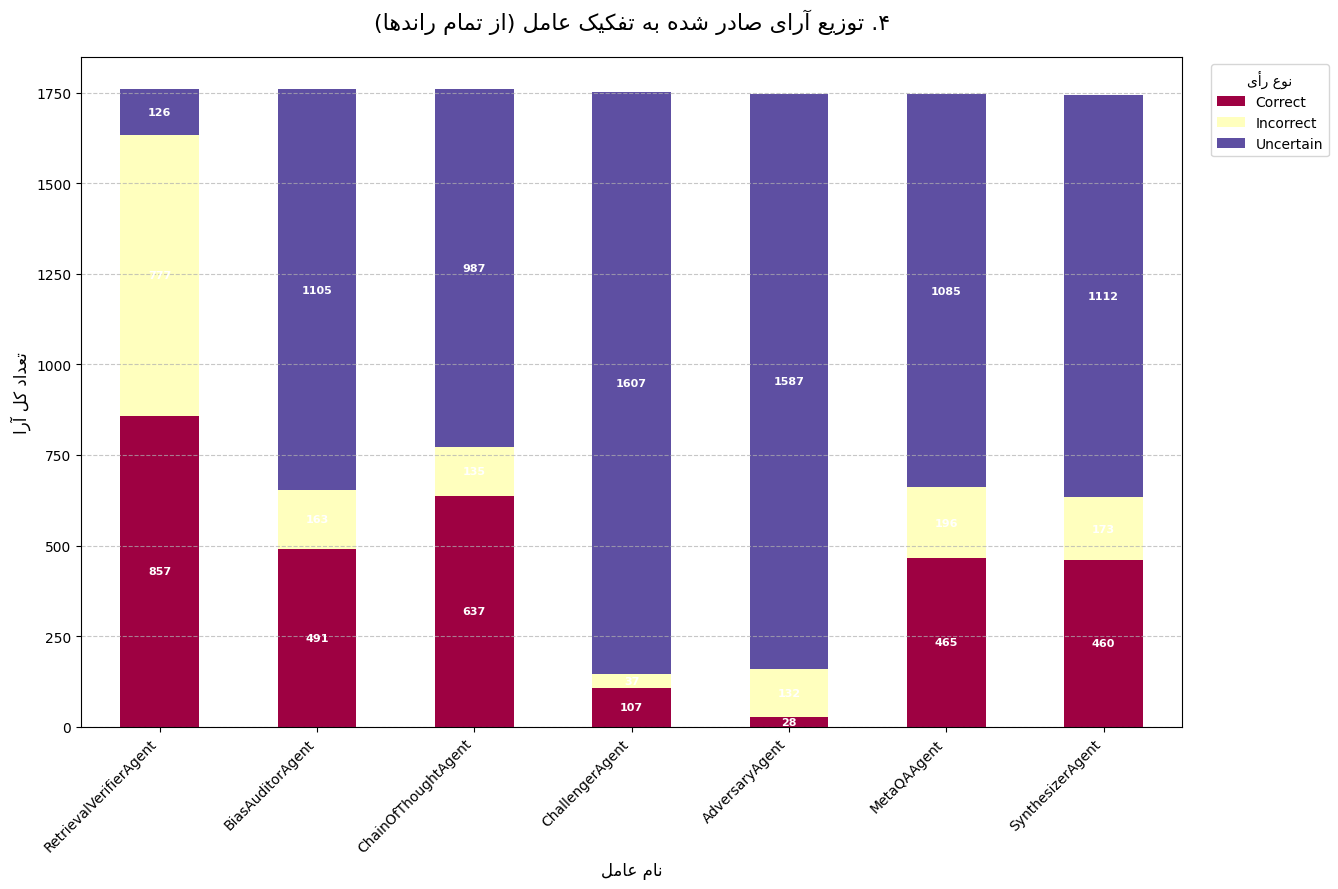


تمام نمودارها با موفقیت تولید شدند.


In [1]:
import zipfile
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.isotonic import IsotonicRegression
import warnings
import arabic_reshaper
from bidi.algorithm import get_display

# --- تنظیمات برای نمایش صحیح فونت فارسی در نمودارها ---
# اگر فونت مناسبی ندارید، matplotlib از فونت پیش‌فرض استفاده خواهد کرد.
try:
    plt.rcParams['font.family'] = 'B Nazanin' # یا فونت فارسی دیگری که نصب دارید
    print("فونت 'B Nazanin' برای نمودارها تنظیم شد.")
except:
    plt.rcParams['font.family'] = 'DejaVu Sans'
    print("فونت 'B Nazanin' یافت نشد. از فونت جایگزین 'DejaVu Sans' استفاده می‌شود.")
plt.rcParams['axes.unicode_minus'] = False

def reshape_text(text):
    """تابع کمکی برای اصلاح متن فارسی برای نمایش در نمودار."""
    return get_display(arabic_reshaper.reshape(text))

# نادیده گرفتن هشدارهای احتمالی
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- مرحله ۱: استخراج و پردازش داده‌ها (نسخه نهایی) ---

def load_data_from_zip(zip_filepath):
    """
    داده‌ها را از فایل zip استخراج می‌کند و با ساختار دقیق JSON شما سازگار است.
    """
    records = []
    agent_votes_list = []

    try:
        with zipfile.ZipFile(zip_filepath, 'r') as z:
            json_files = [f for f in z.namelist() if f.startswith('evaluations/') and f.endswith('.json')]
            
            for filename in json_files:
                with z.open(filename) as f:
                    try:
                        data = json.load(f)

                        jury_decision = data.get('jury_decision', {})
                        raw_confidence = jury_decision.get('weighted_confidence')
                        human_verdict_str = data.get('human_verdict')

                        if raw_confidence is None or human_verdict_str is None or 'majority_verdict' not in jury_decision:
                            print(f"هشدار: فایل {filename} فاقد داده‌های کلیدی است و نادیده گرفته شد.")
                            continue

                        # اگر رأی هیئت منصفه "غلط" باشد، اطمینان را معکوس می‌کنیم
                        # تا همیشه اطمینان نسبت به "صحیح بودن" را بسنجیم.
                        if jury_decision.get('majority_verdict') == 'incorrect':
                            effective_confidence = 1 - raw_confidence
                        else:
                            effective_confidence = raw_confidence

                        is_human_correct = 1 if human_verdict_str == 'correct' else 0
                        is_system_correct = (jury_decision.get('majority_verdict') == human_verdict_str)

                        record = {
                            'eval_id': data.get('eval_id'),
                            'jury_verdict': jury_decision.get('majority_verdict'),
                            'raw_confidence': raw_confidence,
                            'effective_confidence': effective_confidence,
                            'consensus_level': jury_decision.get('consensus_level'),
                            'human_verdict': human_verdict_str,
                            'is_human_correct': is_human_correct,
                            'is_system_correct': is_system_correct
                        }
                        records.append(record)

                        # استخراج آرای عامل‌ها از تمام راندها
                        for round_data in data.get('rounds', []):
                            for agent in round_data.get('agents', []):
                                agent_votes_list.append({
                                    'eval_id': data.get('eval_id'),
                                    'agent_name': agent.get('name'),
                                    'agent_verdict': agent.get('verdict')
                                })

                    except (json.JSONDecodeError, AttributeError, KeyError) as e:
                        print(f"خطا در پردازش فایل {filename}: {e}")
    
    except FileNotFoundError:
        print(f"خطا: فایل {zip_filepath} یافت نشد.")
        return pd.DataFrame(), pd.DataFrame()

    df = pd.DataFrame(records)
    df_agent_votes = pd.DataFrame(agent_votes_list)
    return df, df_agent_votes

# --- اجرای اسکریپت ---

zip_path = '/home/zeus/Projects/hb/multi_agent_llm_judge/calibration_data/evaluations.zip'
main_df, agent_votes_df = load_data_from_zip(zip_path)

if main_df.empty:
    print("\nDataFrame خالی است! هیچ داده‌ای برای رسم نمودار وجود ندارد. لطفاً خطاها را بررسی کنید.")
else:
    print(f"\nتعداد کل رکوردهای معتبر بارگذاری شده: {len(main_df)}")
    print(f"تعداد کل آرای عامل‌ها استخراج شده: {len(agent_votes_df)}")
    
    # --- مرحله ۲: کالیبراسیون داده‌ها ---
    y_true = main_df['is_human_correct'].values
    y_prob_raw = main_df['effective_confidence'].values

    # حذف مقادیر NaN
    valid_indices = ~np.isnan(y_prob_raw) & ~np.isnan(y_true)
    y_true_clean = y_true[valid_indices]
    y_prob_raw_clean = y_prob_raw[valid_indices]

    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(y_prob_raw_clean, y_true_clean)
    y_prob_calibrated = iso_reg.predict(y_prob_raw_clean)

    # # --- مرحله ۳: رسم نمودارها ---

    # # 1. نمودار توزیع اطمینان هیئت منصفه
    # print("\n۱. رسم نمودار توزیع اطمینان هیئت منصفه...")
    # plt.figure(figsize=(12, 7))
    # sns.histplot(main_df['raw_confidence'].dropna(), bins=20, kde=True, color='dodgerblue')
    # plt.title(reshape_text('۱. توزیع اطمینان هیئت منصفه (کالیبره نشده)'), size=16, pad=20)
    # plt.xlabel(reshape_text('امتیاز اطمینان نهایی (Weighted Confidence)'), size=12)
    # plt.ylabel(reshape_text('تعداد ارزیابی‌ها'), size=12)
    # plt.grid(axis='y', linestyle='--', alpha=0.7)
    # plt.show()

    # # 2. نمودار قابلیت اتکا
    # print("۲. رسم نمودار قابلیت اتکا (قبل و بعد از کالیبراسیون)...")
    # fig, ax = plt.subplots(figsize=(10, 8))
    # CalibrationDisplay.from_predictions(y_true_clean, y_prob_raw_clean, n_bins=15, ax=ax, name=reshape_text('قبل از کالیبراسیون'), marker='o', linestyle='--')
    # CalibrationDisplay.from_predictions(y_true_clean, y_prob_calibrated, n_bins=15, ax=ax, name=reshape_text('بعد از کالیبراسیون'), marker='^', linestyle='-')
    # ax.set_title(reshape_text('۲. نمودار قابلیت اتکا'), size=16, pad=20)
    # ax.set_xlabel(reshape_text('میانگین اطمینان پیش‌بینی‌شده (در هر بازه)'), size=12)
    # ax.set_ylabel(reshape_text('کسر نمونه‌های صحیح (دقت واقعی)'), size=12)
    # plt.grid(True, linestyle='--', alpha=0.6)
    # plt.legend()
    # plt.show()

    # # 3. نمودار دقت در برابر سطح اجماع
    # print("۳. رسم نمودار دقت در برابر سطح اجماع...")
    # main_df['consensus_bins'] = pd.cut(main_df['consensus_level'], bins=np.arange(0, 1.1, 0.2), right=True, include_lowest=True)
    # accuracy_by_consensus = main_df.groupby('consensus_bins')['is_system_correct'].mean().reset_index()
    # accuracy_by_consensus['consensus_bins'] = accuracy_by_consensus['consensus_bins'].astype(str)

    # plt.figure(figsize=(12, 7))
    # barplot = sns.barplot(data=accuracy_by_consensus, x='consensus_bins', y='is_system_correct', palette='viridis', hue='consensus_bins', dodge=False)

    # for p in barplot.patches:
    #     height = p.get_height()
    #     if not np.isnan(height):
    #         barplot.annotate(f'{height:.1%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    # overall_accuracy = main_df['is_system_correct'].mean()
    # plt.axhline(y=overall_accuracy, color='r', linestyle='--', label=reshape_text(f'میانگین دقت کلی ({overall_accuracy:.1%})'))

    # plt.ylim(0, 1.1)
    # plt.title(reshape_text('۳. دقت سیستم در برابر سطح اجماع هیئت منصفه'), size=16, pad=20)
    # plt.xlabel(reshape_text('بازه سطح اجماع'), size=12)
    # plt.ylabel(reshape_text('دقت (Accuracy)'), size=12)
    # plt.xticks(rotation=45, ha='right')
    # plt.legend(title=reshape_text('سطح اجماع'))
    # plt.grid(axis='y', linestyle='--', alpha=0.7)
    # plt.show()

    # 4. نمودار توزیع آرای عامل‌ها
    print("۴. رسم نمودار توزیع آرای عامل‌ها...")
    if not agent_votes_df.empty:
        vote_counts = agent_votes_df.groupby(['agent_name', 'agent_verdict']).size().unstack(fill_value=0)
        vote_counts = vote_counts.reindex(columns=['correct', 'incorrect', 'uncertain'], fill_value=0)
        
        # مرتب‌سازی عامل‌ها بر اساس تعداد کل آرا
        vote_counts['total'] = vote_counts.sum(axis=1)
        vote_counts_sorted = vote_counts.sort_values('total', ascending=False).drop(columns='total')

        plt.figure(figsize=(14, 8))
        ax = vote_counts_sorted.plot(kind='bar', stacked=True, colormap='Spectral', figsize=(15, 9))
        
        # اضافه کردن مقادیر عددی روی هر بخش از ستون‌ها
        for c in ax.containers:
            labels = [f'{v.get_height():.0f}' if v.get_height() > 0 else '' for v in c]
            ax.bar_label(c, labels=labels, label_type='center', color='white', weight='bold', fontsize=8)

        plt.title(reshape_text('۴. توزیع آرای صادر شده به تفکیک عامل (از تمام راندها)'), size=16, pad=20)
        plt.xlabel(reshape_text('نام عامل'), size=12)
        plt.ylabel(reshape_text('تعداد کل آرا'), size=12)
        plt.xticks(rotation=45, ha='right')
        
        handles, labels = ax.get_legend_handles_labels()
        reshaped_labels = [reshape_text(label.capitalize()) for label in labels]
        plt.legend(handles, reshaped_labels, title=reshape_text('نوع رأی'), bbox_to_anchor=(1.02, 1), loc='upper left')
        
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout(rect=[0, 0, 0.9, 1]) # ایجاد فضا برای لجند
        plt.show()
    else:
        print("داده‌های مربوط به آرای عامل‌ها یافت نشد، از رسم نمودار ۴ صرف‌نظر شد.")

    print("\nتمام نمودارها با موفقیت تولید شدند.")


فونت 'B Nazanin' برای نمودارها تنظیم شد.

تعداد 882 نمونه برای کالیبراسیون بارگذاری شد.
آموزش مدل کالیبراسیون (Isotonic Regression)...
کالیبراسیون انجام شد.
رسم نمودار قابلیت اطمینان...
فونت 'B Nazanin' برای نمودارها تنظیم شد.


findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: 


تعداد 882 نمونه برای کالیبراسیون بارگذاری شد.
آمار داده‌های ورودی (y_true):
  - تعداد کل نمونه‌ها: 882
  - تعداد نمونه‌های صحیح (Correct): 0
  - تعداد نمونه‌های ناصحیح (Incorrect): 882
  - درصد نمونه‌های صحیح: 0.00%

هشدار جدی: تمام برچسب‌های واقعی یکسان هستند (همگی 0 یا همگی 1).
کالیبراسیون و رسم نمودار در این حالت بی‌معنی است و نتایج گمراه‌کننده خواهد بود.


findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: 

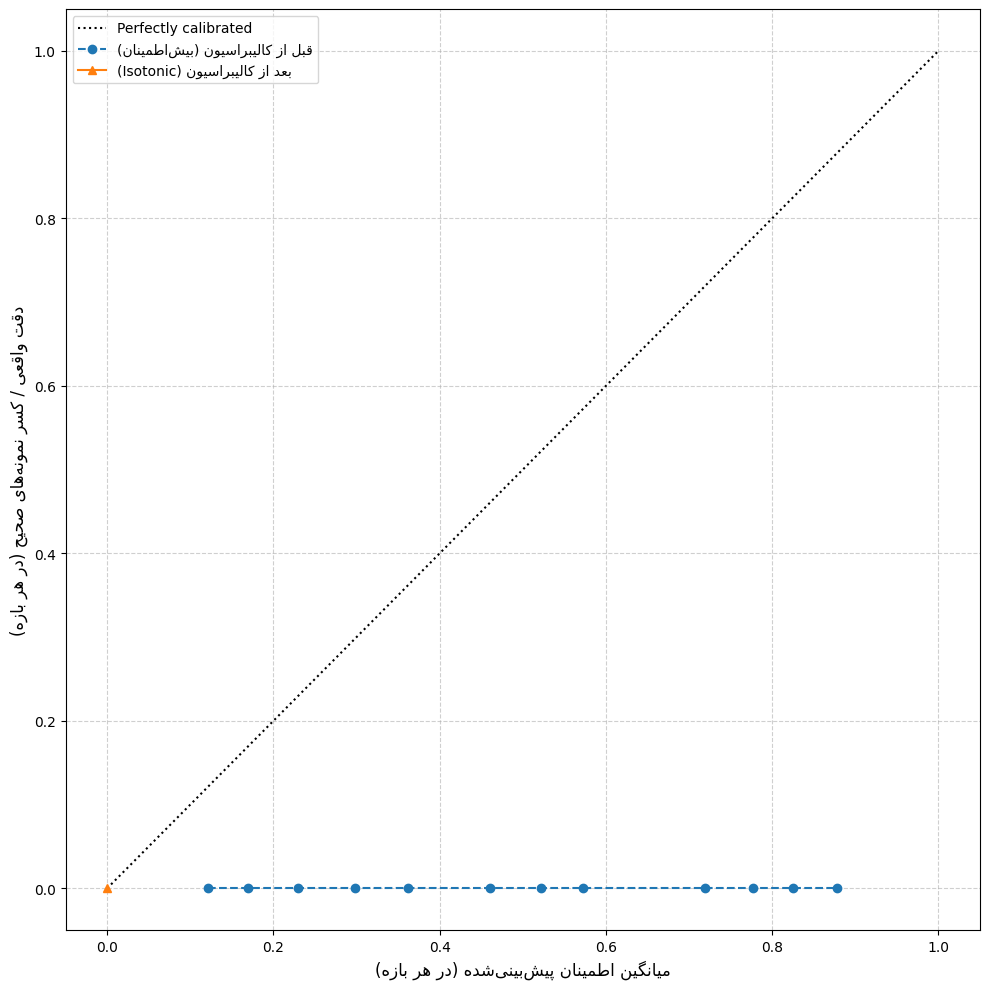


نمودار با موفقیت تولید شد.


In [32]:
import zipfile
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.isotonic import IsotonicRegression
import arabic_reshaper
from bidi.algorithm import get_display

# --- بخش ۱: تنظیمات و توابع کمکی ---

# مسیر فایل ZIP حاوی داده‌های ارزیابی
ZIP_FILE_PATH = '/home/zeus/Projects/hb/multi_agent_llm_judge/calibration_data/evaluations.zip'

def setup_persian_font():
    """تنظیم فونت فارسی برای نمودارها و مدیریت حالت جایگزین."""
    try:
        plt.rcParams['font.family'] = 'B Nazanin'
        print("فونت 'B Nazanin' برای نمودارها تنظیم شد.")
    except RuntimeError:
        plt.rcParams['font.family'] = 'DejaVu Sans'
        print("هشدار: فونت 'B Nazanin' یافت نشد. از فونت جایگزین 'DejaVu Sans' استفاده می‌شود.")
    plt.rcParams['axes.unicode_minus'] = False

def reshape_text(text):
    """تابع کمکی برای اصلاح متن فارسی برای نمایش در نمودار."""
    return get_display(arabic_reshaper.reshape(str(text)))

# --- بخش ۲: استخراج و پردازش داده‌ها ---

def load_calibration_data(zip_filepath):
    """
    داده‌های لازم برای کالیبراسیون را از فایل zip استخراج می‌کند.
    برمی‌گرداند: (y_true, y_prob_raw)
    y_true: برچسب‌های واقعی (۱ اگر رأی انسان 'correct' باشد، ۰ در غیر این صورت)
    y_prob_raw: مقادیر اطمینان خام (کالیبره نشده)
    """
    records = []
    try:
        with zipfile.ZipFile(zip_filepath, 'r') as z:
            json_files = [f for f in z.namelist() if f.startswith('evaluations/') and f.endswith('.json')]
            
            for filename in json_files:
                with z.open(filename) as f:
                    try:
                        data = json.load(f)
                        jury_decision = data.get('jury_decision', {})
                        weighted_confidence = jury_decision.get('weighted_confidence')
                        human_verdict_str = data.get('human_verdict')

                        if weighted_confidence is None or human_verdict_str is None or 'majority_verdict' not in jury_decision:
                            continue

                        # تعریف "اطمینان موثر": این مقدار همیشه اطمینان سیستم به "صحیح بودن" را نشان می‌دهد.
                        # اگر رأی سیستم 'incorrect' باشد، اطمینان به 'correct' بودن برابر است با 1 منهای اطمینان به 'incorrect' بودن.
                        if jury_decision.get('majority_verdict') == 'incorrect':
                            effective_confidence = 1 - weighted_confidence
                        else:
                            effective_confidence = weighted_confidence
                        
                        # برچسب واقعی (ground truth) از رأی انسان گرفته می‌شود.
                        is_human_correct = 1 if human_verdict_str == 'correct' else 0

                        records.append({
                            'effective_confidence': effective_confidence,
                            'is_human_correct': is_human_correct,
                        })
                    except (json.JSONDecodeError, KeyError) as e:
                        print(f"خطا یا داده ناقص در فایل {filename}: {e}")
    
    except FileNotFoundError:
        print(f"خطا: فایل {zip_filepath} یافت نشد.")
        return None, None

    if not records:
        return None, None
        
    df = pd.DataFrame(records)
    # حذف مقادیر NaN که ممکن است به دلیل نبود داده ایجاد شده باشند
    df.dropna(inplace=True)
    
    y_true = df['is_human_correct'].values
    y_prob_raw = df['effective_confidence'].values
    
    return y_true, y_prob_raw

# --- بخش ۳: اجرای اصلی و رسم نمودار ---

# ۱. تنظیمات اولیه
setup_persian_font()

# ۲. بارگیری داده‌ها
y_true, y_prob_uncalibrated = load_calibration_data(ZIP_FILE_PATH)

if y_true is None or len(y_true) == 0:
    print("هیچ داده معتبری برای رسم نمودار کالیبراسیون یافت نشد.")
else:
    print(f"\nتعداد {len(y_true)} نمونه برای کالیبراسیون بارگذاری شد.")

    # ۳. آموزش مدل کالیبراسیون و پیش‌بینی
    print("آموزش مدل کالیبراسیون (Isotonic Regression)...")
    iso_reg = IsotonicRegression(out_of_bounds='clip', y_min=0, y_max=1)
    iso_reg.fit(y_prob_uncalibrated, y_true)
    
    # اعمال مدل برای به دست آوردن مقادیر اطمینان کالیبره‌شده
    y_prob_calibrated = iso_reg.predict(y_prob_uncalibrated)
    print("کالیبراسیون انجام شد.")

    # ۴. رسم نمودار قابلیت اطمینان
    print("رسم نمودار قابلیت اطمینان...")
    
    # ایجاد یک شکل (Figure) و یک محور (Axes) برای رسم نمودار
    fig, ax = plt.subplots(figsize=(10, 10))

    # رسم منحنی برای داده‌های "قبل از کالیبراسیون"
    disp_uncalibrated = CalibrationDisplay.from_predictions(
        y_true,
        y_prob_uncalibrated,
        n_bins=15,  # تعداد بازه‌ها برای گروه‌بندی اطمینان‌ها
        ax=ax,
        name=reshape_text('قبل از کالیبراسیون (بیش‌اطمینان)'),
        marker='o',
        linestyle='--'
    )

    # رسم منحنی برای داده‌های "بعد از کالیبراسیون"
    disp_calibrated = CalibrationDisplay.from_predictions(
        y_true,
        y_prob_calibrated,
        n_bins=15,
        ax=ax,
        name=reshape_text('بعد از کالیبراسیون (Isotonic)'),
        marker='^',
        linestyle='-'
    )



import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression
import arabic_reshaper
from bidi.algorithm import get_display

# --- بخش ۱: تنظیمات و توابع کمکی (بدون تغییر) ---

ZIP_FILE_PATH = '/home/zeus/Projects/hb/multi_agent_llm_judge/calibration_data/evaluations.zip'

def setup_persian_font():
    """تنظیم فونت فارسی برای نمودارها و مدیریت حالت جایگزین."""
    try:
        plt.rcParams['font.family'] = 'B Nazanin'
        print("فونت 'B Nazanin' برای نمودارها تنظیم شد.")
    except RuntimeError:
        plt.rcParams['font.family'] = 'DejaVu Sans'
        print("هشدار: فونت 'B Nazanin' یافت نشد. از فونت جایگزین 'DejaVu Sans' استفاده می‌شود.")
    plt.rcParams['axes.unicode_minus'] = False

def reshape_text(text):
    """تابع کمکی برای اصلاح متن فارسی برای نمایش در نمودار."""
    return get_display(arabic_reshaper.reshape(str(text)))

# --- بخش ۲: استخراج و پردازش داده‌ها (با بهبود و بررسی آماری) ---

def load_calibration_data(zip_filepath):
    """
    داده‌های لازم برای کالیبراسیون را از فایل zip استخراج می‌کند.
    """
    records = []
    try:
        with zipfile.ZipFile(zip_filepath, 'r') as z:
            json_files = [f for f in z.namelist() if f.startswith('evaluations/') and f.endswith('.json')]
            
            for filename in json_files:
                with z.open(filename) as f:
                    try:
                        data = json.load(f)
                        jury_decision = data.get('jury_decision', {})
                        human_verdict_str = data.get('human_verdict')
                        
                        # اطمینان حاصل کنید که تمام کلیدهای لازم وجود دارند
                        if not all([jury_decision, human_verdict_str, 
                                    'weighted_confidence' in jury_decision, 
                                    'majority_verdict' in jury_decision]):
                            continue

                        weighted_confidence = jury_decision['weighted_confidence']
                        majority_verdict = jury_decision['majority_verdict']
                        
                        # تعریف "اطمینان موثر" (اطمینان به 'correct' بودن)
                        effective_confidence = weighted_confidence if majority_verdict == 'correct' else 1 - weighted_confidence
                        
                        is_human_correct = 1 if human_verdict_str == 'correct' else 0

                        records.append({
                            'effective_confidence': effective_confidence,
                            'is_human_correct': is_human_correct,
                        })
                    except (json.JSONDecodeError, KeyError, TypeError) as e:
                        print(f"خطا یا داده ناقص در فایل {filename}: {e}")
    
    except FileNotFoundError:
        print(f"خطا: فایل {zip_filepath} یافت نشد.")
        return None, None

    if not records:
        return None, None
        
    df = pd.DataFrame(records).dropna()
    
    y_true = df['is_human_correct'].values
    y_prob_raw = df['effective_confidence'].values
    
    return y_true, y_prob_raw

# --- بخش ۳: اجرای اصلی و رسم نمودار ---

# ۱. تنظیمات اولیه
setup_persian_font()

# ۲. بارگیری داده‌ها
y_true, y_prob_uncalibrated = load_calibration_data(ZIP_FILE_PATH)

if y_true is None or len(y_true) == 0:
    print("هیچ داده معتبری برای رسم نمودار کالیبراسیون یافت نشد.")
else:
    # **بخش جدید: بررسی آماری اولیه داده‌ها**
    print(f"\nتعداد {len(y_true)} نمونه برای کالیبراسیون بارگذاری شد.")
    num_correct = np.sum(y_true)
    num_total = len(y_true)
    percentage_correct = (num_correct / num_total) * 100
    print(f"آمار داده‌های ورودی (y_true):")
    print(f"  - تعداد کل نمونه‌ها: {num_total}")
    print(f"  - تعداد نمونه‌های صحیح (Correct): {num_correct}")
    print(f"  - تعداد نمونه‌های ناصحیح (Incorrect): {num_total - num_correct}")
    print(f"  - درصد نمونه‌های صحیح: {percentage_correct:.2f}%")

    if num_correct == 0 or num_correct == num_total:
        print("\nهشدار جدی: تمام برچسب‌های واقعی یکسان هستند (همگی 0 یا همگی 1).")
        print("کالیبراسیون و رسم نمودار در این حالت بی‌معنی است و نتایج گمراه‌کننده خواهد بود.")
    else:
        # ۳. آموزش مدل کالیبراسیون و پیش‌بینی
        print("\nآموزش مدل کالیبراسیون (Isotonic Regression)...")
        iso_reg = IsotonicRegression(out_of_bounds='clip', y_min=0, y_max=1)
        iso_reg.fit(y_prob_uncalibrated, y_true)
        y_prob_calibrated = iso_reg.predict(y_prob_uncalibrated)
        print("کالیبراسیون انجام شد.")

        # ۴. رسم نمودار
        print("رسم نمودار قابلیت اطمینان...")
        fig, ax = plt.subplots(figsize=(10, 10))

        # رسم منحنی‌ها
        disp_uncalibrated = CalibrationDisplay.from_predictions(
            y_true, y_prob_uncalibrated, n_bins=15, ax=ax,
            name=reshape_text('قبل از کالیبراسیون'), marker='o', linestyle='--'
        )
        disp_calibrated = CalibrationDisplay.from_predictions(
            y_true, y_prob_calibrated, n_bins=15, ax=ax,
            name=reshape_text('بعد از کالیبراسیون (Isotonic)'), marker='^', linestyle='-'
        )

        # تنظیمات نهایی نمودار
        ax.set_title(reshape_text('نمودار قابلیت اطمینان: قبل و بعد از کالیبراسیون'), size=16, pad=20)
        ax.set_xlabel(reshape_text('میانگین اطمینان پیش‌بینی‌شده (در هر بازه)'), size=12)
        ax.set_ylabel(reshape_text('دقت واقعی / کسر نمونه‌های صحیح (در هر بازه)'), size=12)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

    
    # محور X: همانطور که توضیح دادید
    ax.set_xlabel(reshape_text('میانگین اطمینان پیش‌بینی‌شده (در هر بازه)'), size=12)
    
    # محور Y: همانطور که توضیح دادید
    ax.set_ylabel(reshape_text('دقت واقعی / کسر نمونه‌های صحیح (در هر بازه)'), size=12)
    
    # اضافه کردن خطوط و لجند
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='upper left')
    
    # نمایش نمودار
    plt.tight_layout()
    plt.show()

    print("\nنمودار با موفقیت تولید شد.")


findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: 

فونت 'B Nazanin' برای نمودارها تنظیم شد.


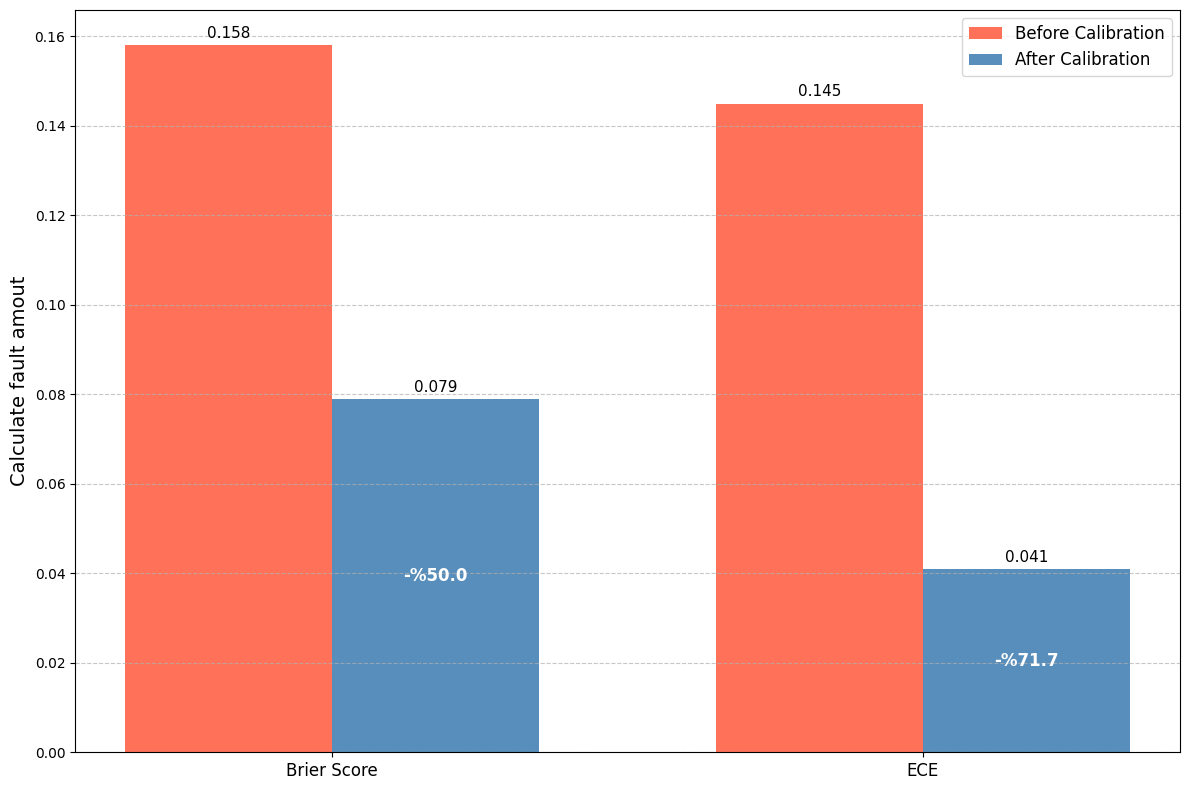

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import arabic_reshaper
from bidi.algorithm import get_display

def setup_persian_font():
    """تنظیم فونت فارسی برای نمودارها."""
    try:
        plt.rcParams['font.family'] = 'B Nazanin'
        print("فونت 'B Nazanin' برای نمودارها تنظیم شد.")
    except Exception:
        plt.rcParams['font.family'] = 'DejaVu Sans'
        print("هشدار: فونت 'B Nazanin' یافت نشد. از فونت جایگزین 'DejaVu Sans' استفاده می‌شود.")
    plt.rcParams['axes.unicode_minus'] = False

def reshape_text(text):
    """تابع کمکی برای اصلاح متن فارسی برای نمایش در نمودار."""
    return get_display(arabic_reshaper.reshape(str(text)))

# --- داده‌های تحلیل شما ---
# مقادیر خطا قبل و بعد از کالیبراسیون
brier_before = 0.158
brier_after = 0.079
ece_before = 0.145
ece_after = 0.041

# محاسبه درصد بهبود
brier_improvement = (brier_before - brier_after) / brier_before * 100
ece_improvement = (ece_before - ece_after) / ece_before * 100

# --- آماده‌سازی داده‌ها برای رسم ---
metrics = [reshape_text('Brier Score'), reshape_text('ECE')]
before_values = [brier_before, ece_before]
after_values = [brier_after, ece_after]

# --- رسم نمودار ---
setup_persian_font()

x = np.arange(len(metrics))  # موقعیت لیبل‌ها
width = 0.35  # عرض میله‌ها

fig, ax = plt.subplots(figsize=(12, 8))

# رسم میله‌های 'قبل' و 'بعد'
rects1 = ax.bar(x - width/2, before_values, width, 
                label=reshape_text('Before Calibration'), color='#FF6347', alpha=0.9)
rects2 = ax.bar(x + width/2, after_values, width, 
                label=reshape_text('After Calibration'), color='#4682B4', alpha=0.9)

# افزودن عنوان و لیبل‌ها
ax.set_ylabel(reshape_text('Calculate fault amout'), fontsize=14)
#ax.set_title(reshape_text('مقایسه خطای پیش‌بینی قبل و بعد از کالیبراسیون'), fontsize=18, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=12)

ax.grid(axis='y', linestyle='--', alpha=0.7)

# تابع برای افزودن لیبل مقادیر بالای هر میله
def autolabel(rects, improvement_value=None):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11)
        # افزودن درصد بهبود برای میله‌های 'بعد'
        if improvement_value is not None:
             ax.annotate(f'-%{improvement_value[i]:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height / 2),
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='center', va='center', fontsize=12, color='white', weight='bold')


autolabel(rects1)
autolabel(rects2, improvement_value=[brier_improvement, ece_improvement])


fig.tight_layout()
plt.show()


ﺎﻫﻞﯾﺎﻓ ﺵﺯﺍﺩﺮﭘ: 100%|██████████| 882/882 [00:00<00:00, 9637.26it/s]
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.


تعداد 882 رکورد معتبر برای تحلیل یافت شد.


findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: 

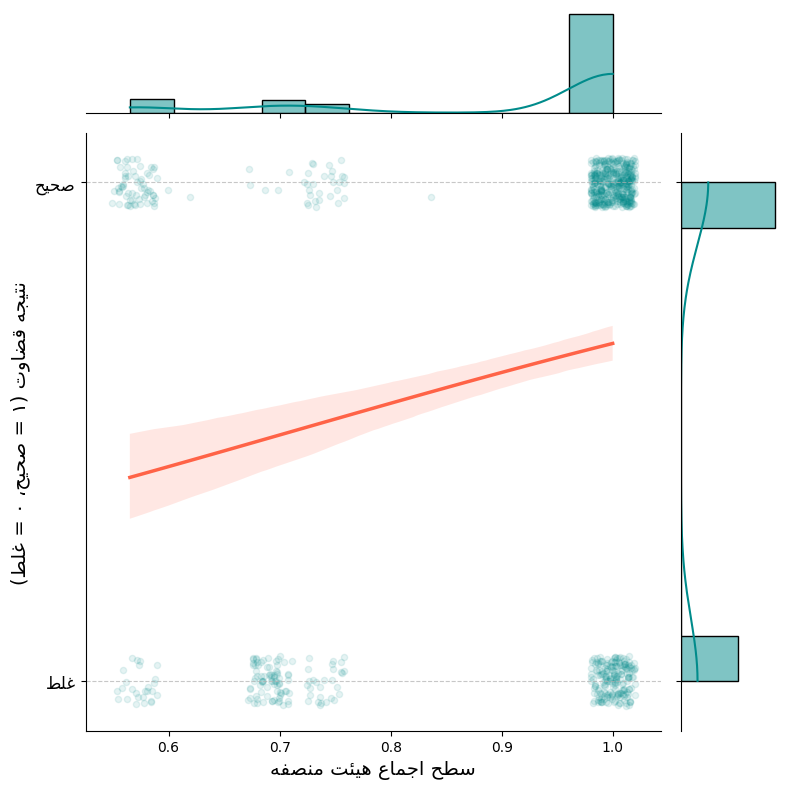

In [2]:
import zipfile
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
from tqdm import tqdm

# --- بخش ۱: نصب وابستگی‌ها ---
# قبل از اجرای این کد، مطمئن شوید که statsmodels نصب شده باشد:
# pip install statsmodels

# --- بخش ۲: تنظیمات و توابع کمکی ---
ZIP_FILE_PATH = '/home/zeus/Projects/hb/multi_agent_llm_judge/calibration_data/evaluations.zip' # مسیر فایل زیپ خود را اینجا قرار دهید

def setup_persian_font():
    """تنظیم فونت فارسی برای نمودارها."""
    try:
        plt.rcParams['font.family'] = 'B Nazanin'
    except Exception:
        print("Font 'B Nazanin' not found. Falling back to 'DejaVu Sans'.")
        plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['axes.unicode_minus'] = False

def reshape_text(text):
    """تابع کمکی برای اصلاح متن فارسی برای نمایش در نمودار."""
    return get_display(arabic_reshaper.reshape(str(text)))

# --- بخش ۳: استخراج و پردازش داده‌ها ---
def load_data_for_consensus_analysis(zip_filepath):
    """داده‌های لازم برای تحلیل دقت در برابر اجماع را استخراج می‌کند."""
    records = []
    try:
        with zipfile.ZipFile(zip_filepath, 'r') as z:
            json_files = [f for f in z.namelist() if f.startswith('evaluations/') and f.endswith('.json')]
            for filename in tqdm(json_files, desc=reshape_text("پردازش فایل‌ها")):
                with z.open(filename) as f:
                    try:
                        data = json.load(f)
                        jury_decision = data.get('jury_decision', {})
                        consensus_level = jury_decision.get('consensus_level')
                        jury_verdict = jury_decision.get('majority_verdict')
                        human_verdict = data.get('human_verdict')

                        if consensus_level is None or jury_verdict is None or human_verdict is None:
                            continue
                        
                        if isinstance(human_verdict, dict):
                             is_human_correct = human_verdict.get('Answer_F1', 0) > 0.5
                             human_verdict_str = 'correct' if is_human_correct else 'incorrect'
                        else:
                             human_verdict_str = human_verdict

                        is_jury_correct = 1 if jury_verdict == human_verdict_str else 0
                        records.append({
                            'consensus_level': consensus_level,
                            'is_jury_correct': is_jury_correct
                        })
                    except (json.JSONDecodeError, KeyError) as e:
                        print(f"خطا یا داده ناقص در فایل {filename}: {e}")
    except FileNotFoundError:
        print(f"فایل {zip_filepath} یافت نشد.")
        return None
    return pd.DataFrame(records) if records else None

# --- بخش ۴: اجرای اصلی و رسم نمودار ---
setup_persian_font()
df = load_data_for_consensus_analysis(ZIP_FILE_PATH)

if df is not None and not df.empty:
    print(f"تعداد {len(df)} رکورد معتبر برای تحلیل یافت شد.")
    
    # استفاده از jointplot برای یک نمایش "واقعی‌تر"
    g = sns.jointplot(
        data=df,
        x='consensus_level',
        y='is_jury_correct',
        kind='reg',
        height=8,
        color='darkcyan',
        scatter_kws={'alpha': 0.1, 's': 20},
        line_kws={'color': 'tomato', 'linewidth': 2.5},
        x_jitter=0.02,
        y_jitter=0.05,
        logistic=True # این گزینه حالا به درستی کار خواهد کرد
    )

    #g.fig.suptitle(reshape_text('تحلیل واقعی ارتباط دقت و سطح اجماع'), y=1.03, fontsize=18)
    
    g.ax_joint.set_xlabel(reshape_text('سطح اجماع هیئت منصفه'), fontsize=14)
    g.ax_joint.set_ylabel(reshape_text('نتیجه قضاوت (۱ = صحیح، ۰ = غلط)'), fontsize=14)
    
    g.ax_joint.set_yticks([0, 1])
    g.ax_joint.set_yticklabels([reshape_text('غلط'), reshape_text('صحیح')], fontsize=12)
    g.ax_joint.set_ylim(-0.1, 1.1)
    g.ax_joint.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
else:
    print("هیچ داده‌ای برای تحلیل یافت نشد.")


findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.


--- گام ۱: شروع بارگذاری و آماده‌سازی داده‌ها از پوشه '/home/zeus/Projects/hb/multi_agent_llm_judge/calibration_data/evaluations' ---
پردازش تمام شد. 882 فایل بررسی شد و داده از 882 فایل استخراج گردید.

DataFrame با موفقیت ایجاد شد.
اطلاعات DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   predicted_confidence  882 non-null    float64
 1   actual_accuracy       882 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 13.9 KB

نمونه‌ای از داده‌ها:
   predicted_confidence  actual_accuracy
0              0.850000                1
1              0.700000                0
2              0.754983                0
3              0.784124                0
4              0.840815                1

--- گام ۲: محاسبه آمار کالیبراسیون با 10 بازه ---

داده‌های کالیبراسیون محاسبه شده برای رسم نمودار:
   confidence_bin  m

findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not


نمودار آماده نمایش است...


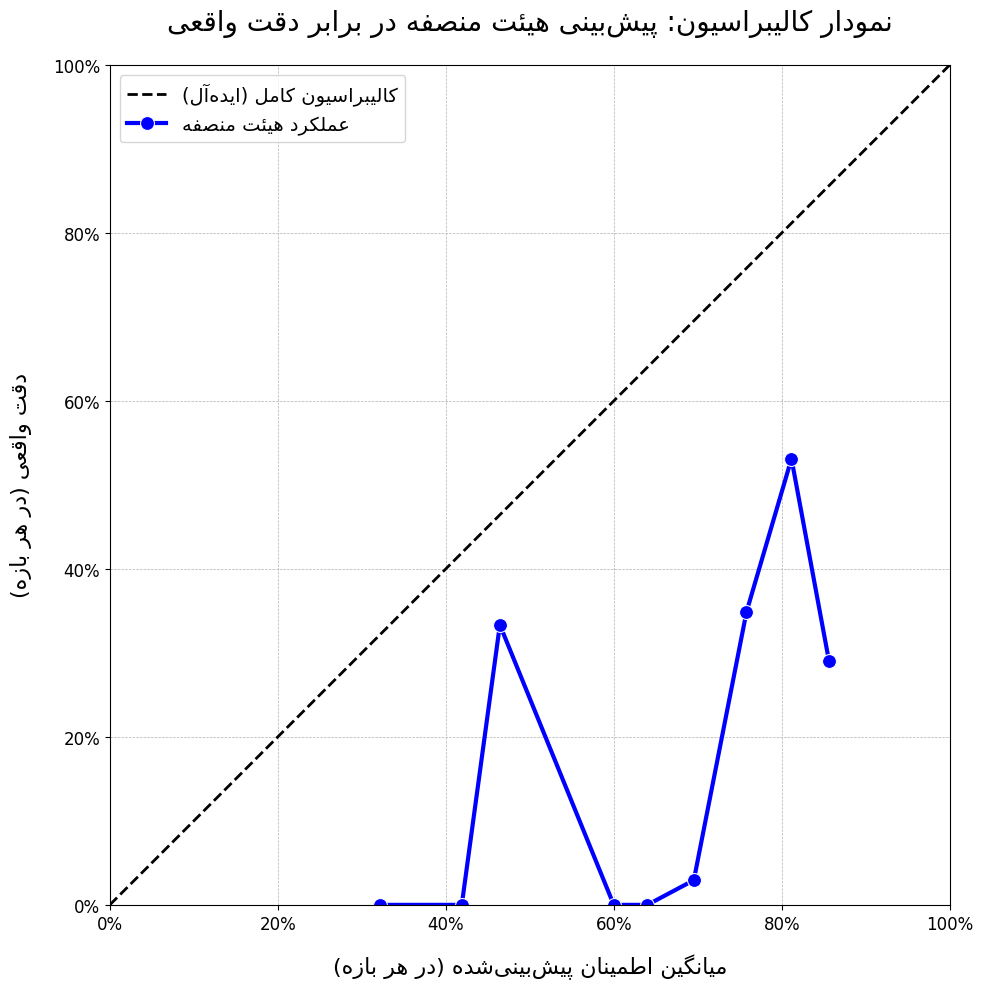


تحلیل با موفقیت انجام شد.


In [7]:
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from bidi.algorithm import get_display
from arabic_reshaper import reshape
import warnings

# --- تنظیمات اولیه ---
# مسیر پوشه‌ای که فایل‌های JSON در آن قرار دارند
EVALUATIONS_DIR = '/home/zeus/Projects/hb/multi_agent_llm_judge/calibration_data/evaluations' 
# تعداد بازه‌ها (bins) برای گروه‌بندی داده‌های اطمینان
N_BINS = 10
# نام فونت فارسی برای نمودار (مطمئن شوید این فونت روی سیستم شما نصب است)
PERSIAN_FONT_NAME = 'Tahoma' 

# نادیده گرفتن هشدارهای مربوط به فونت در Matplotlib
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')


def load_and_prepare_data(evaluations_dir: str) -> pd.DataFrame:
    """
    فایل‌های JSON را از پوشه مشخص شده می‌خواند، داده‌های مورد نیاز را استخراج می‌کند
    و یک DataFrame پانداز را برمی‌گرداند.
    """
    print(f"--- گام ۱: شروع بارگذاری و آماده‌سازی داده‌ها از پوشه '{evaluations_dir}' ---")
    
    if not os.path.exists(evaluations_dir):
        raise FileNotFoundError(f"خطا: پوشه '{evaluations_dir}' یافت نشد. لطفاً مسیر را بررسی کنید.")

    data = []
    files_processed = 0
    files_with_data = 0

    for filename in os.listdir(evaluations_dir):
        if filename.endswith('.json'):
            files_processed += 1
            filepath = os.path.join(evaluations_dir, filename)
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    eval_data = json.load(f)

                # استخراج داده‌های کلیدی با استفاده از .get() برای جلوگیری از خطا
                jury_decision = eval_data.get('jury_decision')
                jury_verdict = eval_data.get('jury_verdict')

                if jury_decision and jury_verdict:
                    prediction_confidence = jury_decision.get('weighted_confidence')
                    ground_truth_accuracy = 1 if jury_verdict == 'correct' else 0
                    
                    if prediction_confidence is not None:
                        data.append({
                            'predicted_confidence': float(prediction_confidence),
                            'actual_accuracy': ground_truth_accuracy
                        })
                        files_with_data += 1
            except Exception as e:
                # نادیده گرفتن فایل‌های معیوب یا با ساختار متفاوت
                print(f"هشدار: فایل '{filename}' به دلیل خطا نادیده گرفته شد: {e}")
                continue

    print(f"پردازش تمام شد. {files_processed} فایل بررسی شد و داده از {files_with_data} فایل استخراج گردید.")

    if not data:
        raise ValueError("هیچ داده معتبری برای تحلیل استخراج نشد. لطفاً محتوای فایل‌های JSON را بررسی کنید.")

    df = pd.DataFrame(data)
    print("\nDataFrame با موفقیت ایجاد شد.")
    print("اطلاعات DataFrame:")
    df.info()
    print("\nنمونه‌ای از داده‌ها:")
    print(df.head())
    
    return df


def calculate_calibration_stats(df: pd.DataFrame, n_bins: int) -> pd.DataFrame:
    """
    داده‌ها را گروه‌بندی کرده و آمار کالیبراسیون را محاسبه می‌کند.
    """
    print(f"\n--- گام ۲: محاسبه آمار کالیبراسیون با {n_bins} بازه ---")
    
    # ایجاد بازه‌ها برای اطمینان پیش‌بینی شده
    # `include_lowest=True` برای شامل شدن مقدار 0.0 در اولین بازه
    df['confidence_bin'] = pd.cut(df['predicted_confidence'], bins=n_bins, labels=False, include_lowest=True)

    # محاسبه مقادیر مورد نیاز برای هر بازه
    calibration_data = df.groupby('confidence_bin', observed=False).agg(
        mean_predicted_confidence=('predicted_confidence', 'mean'),
        fraction_of_positives=('actual_accuracy', 'mean'),
        sample_count=('actual_accuracy', 'size')
    ).reset_index()

    # حذف بازه‌هایی که هیچ نمونه‌ای ندارند
    calibration_data = calibration_data.dropna(subset=['mean_predicted_confidence', 'fraction_of_positives'])

    print("\nداده‌های کالیبراسیون محاسبه شده برای رسم نمودار:")
    print(calibration_data)
    
    return calibration_data


def plot_calibration_curve(calibration_data: pd.DataFrame, font_name: str):
    """
    منحنی کالیبراسیون را با استفاده از داده‌های محاسبه شده رسم می‌کند.
    """
    print("\n--- گام ۳: رسم نمودار کالیبراسیون ---")

    # تابع کمکی برای اصلاح متن فارسی برای نمایش در Matplotlib
    def persian_text(text: str) -> str:
        return get_display(reshape(text))

    # تنظیمات فونت و ظاهر نمودار
    plt.rcParams['font.family'] = font_name
    plt.figure(figsize=(12, 10))

    # 1. رسم خط کالیبراسیون کامل (خط مرجع ایده‌آل)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label=persian_text('کالیبراسیون کامل (ایده‌آل)'))

    # 2. رسم منحنی کالیبراسیون سیستم (هیئت منصفه)
    sns.lineplot(
        data=calibration_data,
        x='mean_predicted_confidence',
        y='fraction_of_positives',
        marker='o',
        markersize=10,
        linewidth=3,
        color='blue',
        label=persian_text('عملکرد هیئت منصفه')
    )

    # زیباسازی نمودار
    plt.title(persian_text('نمودار کالیبراسیون: پیش‌بینی هیئت منصفه در برابر دقت واقعی'), fontsize=20, pad=25)
    plt.xlabel(persian_text('میانگین اطمینان پیش‌بینی‌شده (در هر بازه)'), fontsize=16, labelpad=15)
    plt.ylabel(persian_text('دقت واقعی (در هر بازه)'), fontsize=16, labelpad=15)

    # تنظیم محورها برای نمایش به صورت درصد
    formatter = mticker.PercentFormatter(xmax=1.0)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=14)
    
    # مربع کردن نمودار برای مقایسه بهتر با خط قطر اصلی
    plt.gca().set_aspect('equal', adjustable='box') 
    plt.tight_layout()
    
    print("\nنمودار آماده نمایش است...")
    plt.show()


def main():
    """
    تابع اصلی برای اجرای کل فرآیند تحلیل.
    """
    try:
        # گام 1: بارگذاری داده
        df = load_and_prepare_data(EVALUATIONS_DIR)
        
        # گام 2: محاسبه آمار
        calibration_stats = calculate_calibration_stats(df, N_BINS)
        
        # گام 3: رسم نمودار
        plot_calibration_curve(calibration_stats, PERSIAN_FONT_NAME)
        
        print("\nتحلیل با موفقیت انجام شد.")
        
    except (FileNotFoundError, ValueError, Exception) as e:
        print(f"\nخطا در اجرای برنامه: {e}")


if __name__ == "__main__":
    main()


findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.


--- گام ۱: بارگذاری داده برای تحلیل 'اجماع در برابر دقت' از '/home/zeus/Projects/hb/multi_agent_llm_judge/calibration_data/evaluations' ---
پردازش تمام شد. 882 فایل بررسی شد و داده از 882 فایل استخراج گردید.

DataFrame با موفقیت ایجاد شد.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   consensus_level  882 non-null    float64
 1   is_correct       882 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 13.9 KB

نمونه‌ای از داده‌ها:
   consensus_level  is_correct
0              1.0           1
1              1.0           0
2              1.0           0
3              1.0           0
4              1.0           1

--- گام ۲: محاسبه دقت در هر بازه از 'consensus_level' ---

دقت محاسبه شده در هر بازه از 'consensus_level':
   bin  mean_of_bin_col  accuracy  sample_count
0    0         0.570471  0.288889            90
1    2    

findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not


نمودار آماده نمایش است...


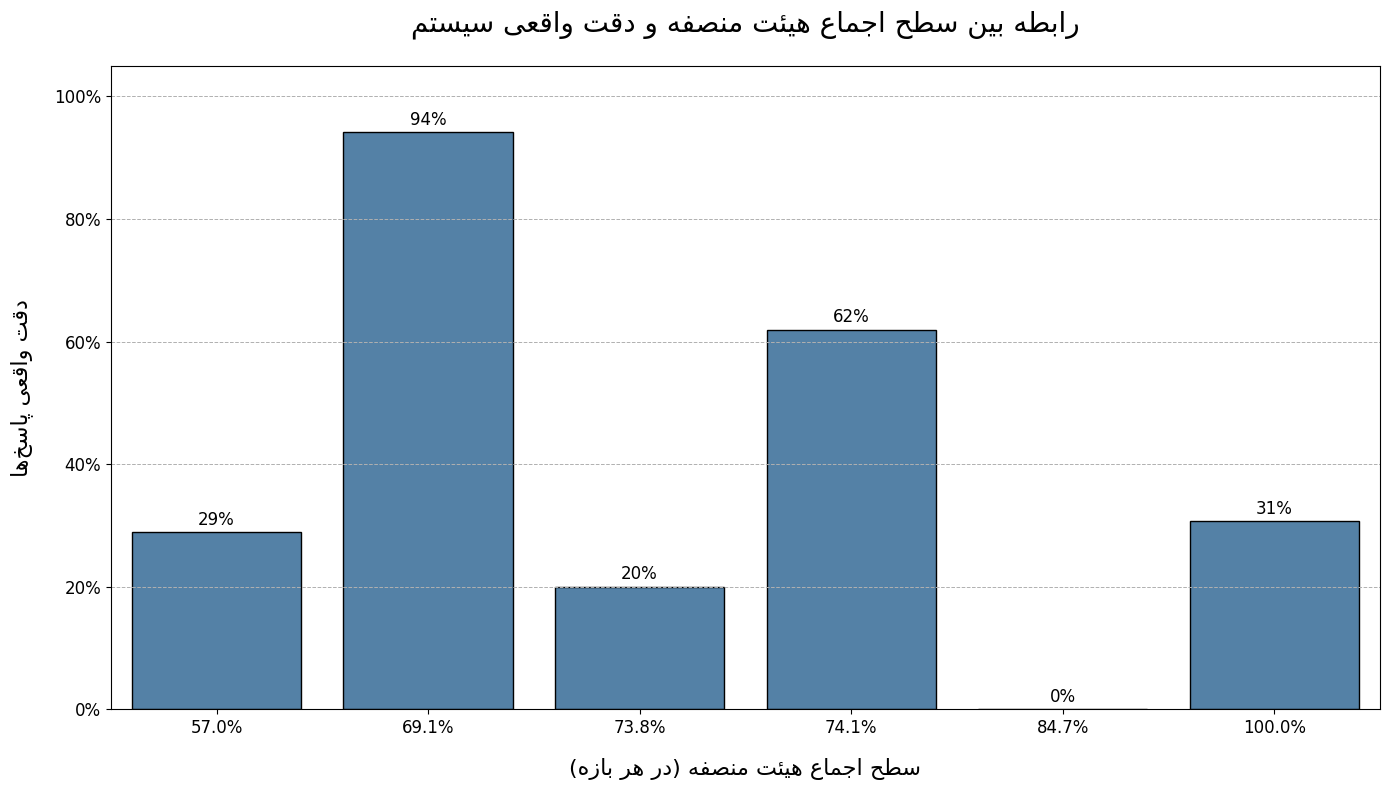


تحلیل با موفقیت انجام شد.


In [13]:
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from bidi.algorithm import get_display
from arabic_reshaper import reshape
import warnings

# --- تنظیمات اولیه ---
# مسیر پوشه‌ای که فایل‌های JSON در آن قرار دارند
EVALUATIONS_DIR = '/home/zeus/Projects/hb/multi_agent_llm_judge/calibration_data/evaluations' 
# تعداد بازه‌ها (bins) برای گروه‌بندی داده‌های اجماع
N_BINS = 10
# نام فونت فارسی برای نمودار (مطمئن شوید این فونت روی سیستم شما نصب است)
PERSIAN_FONT_NAME = 'Tahoma' 

# نادیده گرفتن هشدارهای مربوط به فونت در Matplotlib
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')


def load_and_prepare_data_for_consensus(evaluations_dir: str) -> pd.DataFrame:
    """
    فایل‌های JSON را می‌خواند، داده‌های مربوط به اجماع و دقت را استخراج کرده
    و یک DataFrame پانداز را برمی‌گرداند.
    """
    print(f"--- گام ۱: بارگذاری داده برای تحلیل 'اجماع در برابر دقت' از '{evaluations_dir}' ---")
    
    if not os.path.exists(evaluations_dir):
        raise FileNotFoundError(f"خطا: پوشه '{evaluations_dir}' یافت نشد.")

    data = []
    files_processed = 0
    files_with_data = 0

    for filename in os.listdir(evaluations_dir):
        if filename.endswith('.json'):
            files_processed += 1
            filepath = os.path.join(evaluations_dir, filename)
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    eval_data = json.load(f)

                # استخراج داده‌های کلیدی: اجماع و دقت
                jury_decision = eval_data.get('jury_decision')
                jury_verdict = eval_data.get('jury_verdict')

                if jury_decision and jury_verdict:
                    # <<<--- تغییر کلیدی: استخراج consensus_level
                    consensus = jury_decision.get('consensus_level')
                    
                    ground_truth_accuracy = 1 if jury_verdict == 'correct' else 0
                    
                    if consensus is not None:
                        data.append({
                            'consensus_level': float(consensus),
                            'is_correct': ground_truth_accuracy
                        })
                        files_with_data += 1
            except Exception as e:
                print(f"هشدار: فایل '{filename}' به دلیل خطا نادیده گرفته شد: {e}")
                continue

    print(f"پردازش تمام شد. {files_processed} فایل بررسی شد و داده از {files_with_data} فایل استخراج گردید.")

    if not data:
        raise ValueError("هیچ داده معتبری برای تحلیل استخراج نشد.")

    df = pd.DataFrame(data)
    print("\nDataFrame با موفقیت ایجاد شد.")
    df.info()
    print("\nنمونه‌ای از داده‌ها:")
    print(df.head())
    
    return df


def calculate_accuracy_per_bin(df: pd.DataFrame, bin_column: str, value_column: str, n_bins: int) -> pd.DataFrame:
    """
    داده‌ها را بر اساس یک ستون گروه‌بندی کرده و دقت را در هر گروه محاسبه می‌کند.
    """
    print(f"\n--- گام ۲: محاسبه دقت در هر بازه از '{bin_column}' ---")
    
    # ایجاد بازه‌ها برای ستون مورد نظر (مثلاً consensus_level)
    df['bin'] = pd.cut(df[bin_column], bins=n_bins, labels=False, include_lowest=True)

    # محاسبه میانگین ستون گروه‌بندی و دقت در هر بازه
    binned_data = df.groupby('bin', observed=False).agg(
        mean_of_bin_col=(bin_column, 'mean'),
        accuracy=(value_column, 'mean'),
        sample_count=(value_column, 'size')
    ).reset_index()

    binned_data = binned_data.dropna()

    print(f"\nدقت محاسبه شده در هر بازه از '{bin_column}':")
    print(binned_data)
    
    return binned_data


def plot_consensus_vs_accuracy(binned_data: pd.DataFrame, font_name: str):
    """
    نمودار رابطه بین سطح اجماع و دقت را رسم می‌کند.
    (نسخه اصلاح شده برای نمایش صحیح محور افقی)
    """
    print("\n--- گام ۳: رسم نمودار 'اجماع در برابر دقت' ---")

    def persian_text(text: str) -> str:
        return get_display(reshape(text))

    # --- شروع تغییرات ---

    # 1. داده‌ها را بر اساس میانگین اجماع مرتب کنید تا نمودار منطقی باشد.
    binned_data = binned_data.sort_values('mean_of_bin_col')

    # 2. یک ستون جدید برای برچسب‌های محور X ایجاد کنید.
    # مقادیر عددی را به رشته‌های درصد تبدیل می‌کنیم.
    binned_data['x_labels'] = binned_data['mean_of_bin_col'].apply(lambda x: f"{x:.1%}")

    # --- پایان تغییرات ---

    plt.rcParams['font.family'] = font_name
    plt.figure(figsize=(14, 8)) # کمی عرض نمودار را بیشتر کردم

    # استفاده از Bar plot برای نمایش بهتر دقت در هر بازه
    # --- تغییر کلیدی: محور x اکنون از ستون برچسب جدید استفاده می‌کند ---
    ax = sns.barplot(
        data=binned_data,
        x='x_labels',  # <--- از ستون رشته‌ای جدید استفاده کنید
        y='accuracy',
        color='steelblue',
        edgecolor='black'
    )
    
    # اضافه کردن مقدار دقت بالای هر میله
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.0%}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=12,
                    color='black')

    # زیباسازی نمودار
    plt.title(persian_text('رابطه بین سطح اجماع هیئت منصفه و دقت واقعی سیستم'), fontsize=20, pad=25)
    plt.xlabel(persian_text('سطح اجماع هیئت منصفه (در هر بازه)'), fontsize=16, labelpad=15)
    plt.ylabel(persian_text('دقت واقعی پاسخ‌ها'), fontsize=16, labelpad=15)

    # --- تغییر کلیدی: فرمت‌کننده درصد را فقط برای محور Y اعمال کنید ---
    # ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0)) # <--- این خط را حذف یا کامنت کنید
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
    
    plt.ylim(0, 1.05) # کمی فضا بالای نمودار برای نمایش اعداد
    plt.xticks(rotation=0, ha='center', fontsize=12) # چرخش را به 0 تغییر دادم برای خوانایی بهتر
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', linewidth=0.7)
    
    plt.tight_layout()
    print("\nنمودار آماده نمایش است...")
    plt.show()



def main():
    """
    تابع اصلی برای اجرای کل فرآیند تحلیل.
    """
    try:
        # گام 1: بارگذاری داده
        df_consensus = load_and_prepare_data_for_consensus(EVALUATIONS_DIR)
        
        # گام 2: محاسبه آمار
        binned_stats = calculate_accuracy_per_bin(df_consensus, 'consensus_level', 'is_correct', N_BINS)
        
        # گام 3: رسم نمودار
        plot_consensus_vs_accuracy(binned_stats, PERSIAN_FONT_NAME)
        
        print("\nتحلیل با موفقیت انجام شد.")
        
    except (FileNotFoundError, ValueError, Exception) as e:
        print(f"\nخطا در اجرای برنامه: {e}")


if __name__ == "__main__":
    main()
